In [ ]:
!pip install eco2ai

In [ ]:
import sys
sys.path.append('/kaggle/input/tcsa_snn/pytorch/tcsa_snn_attention/1')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

import resnet_2_copy

from datetime import datetime
import glob
import random

from eco2ai import Tracker
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2_copy.resnet34().to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 4, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 4, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 4, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12           [32, 4, 1, 1, 1]               0
           Conv3d-13           [32, 1, 1, 1, 1]               4
             ReLU-14           [32, 1, 

In [4]:
IMG_DIR      =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [5]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3
Batch_size  = 32
num_epochs  = 60
num_workers = 4
IMAGE_HEIGHT = 256 
IMAGE_WIDTH  = 256 
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None

In [6]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    tracker = Tracker(
        project_name="TCSA_SNN_Training_Project",
        experiment_description="Training TCSA Spiking Model",
        file_name="TCSA_SNN_eco2ai_logs.csv",
        alpha_2_code="EG",
    )
    tracker.start()

    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device)

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

    tracker.stop()

    nasar = model.calculate_nasar()

    return running_loss/len(loader), nasar

In [7]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2_copy.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]
    train_nasar=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        val_acc_loaded, val_dice_loaded = check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

In [8]:
if __name__ == "__main__":
    main()

100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0579]


NASAR: 0.24039096563634738


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0618]


NASAR: 0.2328722868726847


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0454]


NASAR: 0.2203930330948091


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.03]  


NASAR: 0.23115909379412872


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.0276]


NASAR: 0.2211541816102507


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.038] 


NASAR: 0.2083968220742096


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.032] 


NASAR: 0.2146709424229295


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0297]


NASAR: 0.21259692912930053


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0258]


NASAR: 0.20773370053286844


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0321]


NASAR: 0.1979096641003246


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0222]


NASAR: 0.18977569078615575


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0213]


NASAR: 0.1946037811852397


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0154]


NASAR: 0.18291733074635966


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.023] 


NASAR: 0.19245508579021328


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0221]


NASAR: 0.18840859641491528


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0274]


NASAR: 0.17155614145484888


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.018] 


NASAR: 0.17524619841239822


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0232]


NASAR: 0.16871656498438875


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0267]


NASAR: 0.164642548896897


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0183]


NASAR: 0.16868995165041356


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0253]


NASAR: 0.15206757845453253


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0214]


NASAR: 0.16790883417980212


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0255]


NASAR: 0.15581890339023072


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.0205]


NASAR: 0.1537347892080674


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.018] 


NASAR: 0.16314862031891872


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0192]


NASAR: 0.15669596139254144


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0212]


NASAR: 0.1600511846408038


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0175]


NASAR: 0.1462994248654361


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0271]


NASAR: 0.15018141661451456


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0163]


NASAR: 0.1521277450060061


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0155]


NASAR: 0.14757971248716256


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0207]


NASAR: 0.1386797909445606


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0151] 


NASAR: 0.14790714066912872


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.00974]


NASAR: 0.15351907971879125


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0144]


NASAR: 0.14535661258607963


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.018] 


NASAR: 0.12646947332391156


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0136]


NASAR: 0.12990726775406672


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.018] 


NASAR: 0.13073220051510234


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.0135] 


NASAR: 0.1301389971809208


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0102]


NASAR: 0.13904060220494516


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0133] 


NASAR: 0.14219780147355487


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.014]  


NASAR: 0.13031181371267972


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0134] 


NASAR: 0.13686797988246863


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.0157] 


NASAR: 0.13513857881787797


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0172] 


NASAR: 0.13054065077517513


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0115] 


NASAR: 0.13084386547966181


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0226] 


NASAR: 0.13231853252285522


100%|██████████| 82/82 [02:44<00:00,  2.00s/it, loss=0.0119] 


NASAR: 0.13530359581602572


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0164] 


NASAR: 0.11701058222094612


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0122] 


NASAR: 0.1302352421720263


100%|██████████| 82/82 [02:45<00:00,  2.01s/it, loss=0.0146] 


NASAR: 0.11865876426159495


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0139] 


NASAR: 0.12884525066250366


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0141] 


NASAR: 0.11906191328881492


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0099] 


NASAR: 0.12791308550767497


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0126] 


NASAR: 0.11951574585247488


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0111] 


NASAR: 0.11537107727337331


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0126] 


NASAR: 0.12789546268087038


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0123] 


NASAR: 0.11690968974655223


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0113] 


NASAR: 0.11840469288714055


100%|██████████| 82/82 [02:44<00:00,  2.01s/it, loss=0.0108] 


NASAR: 0.11876135812678808


✅ Log loaded successfully.

🔍 Summary:
   🕒 Duration: 9881.24 seconds
   ⚡ Power Consumed: 0.2505 kWh
   🌱 CO₂ Emissions: 0.1179 kg
✅ Summary plot saved as 'TCSA_SNN_eco2ai_summary_plot.png'.


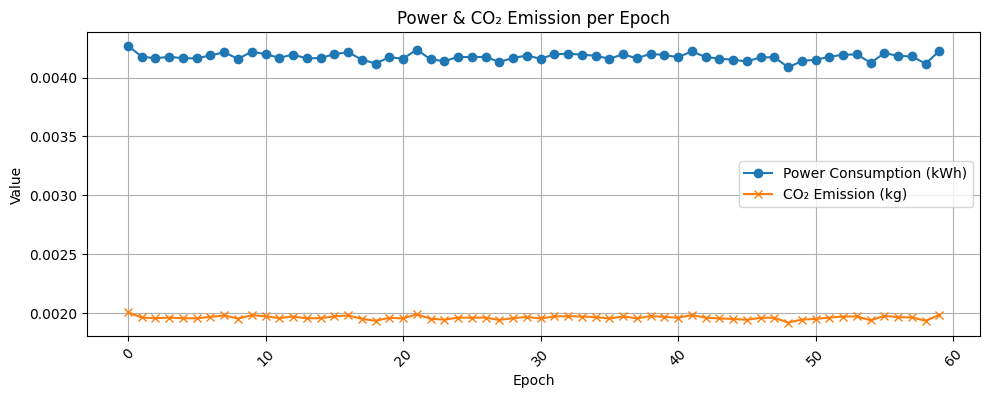

In [9]:
summarize_eco2ai_log("TCSA_SNN_eco2ai_logs.csv")